In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_circles
import seaborn as sns
import os
from scipy import stats

In [2]:
fileroot='/Users/jac/Documents/CD48_Feb19/'
figureroot=fileroot+'Figures/'

In [3]:
cd4=pd.read_pickle(fileroot+'Data/CD4_sequences.pkl')
cd8=pd.read_pickle(fileroot+'Data/CD8_sequences.pkl')

In [4]:
for i in range(7):
    print('Subject '+str(i+1)+':')
    print('   CD4:',cd4[cd4.Subject==i].shape[0])
    print('   CD8:',cd8[cd8.Subject==i].shape[0])
print('Total:')
print('   CD4:'+str(cd4.shape[0]))
print('   CD8:'+str(cd8.shape[0]))

Subject 1:
   CD4: 11751
   CD8: 4676
Subject 2:
   CD4: 9961
   CD8: 2007
Subject 3:
   CD4: 20342
   CD8: 2685
Subject 4:
   CD4: 4310
   CD8: 7049
Subject 5:
   CD4: 17251
   CD8: 6658
Subject 6:
   CD4: 772
   CD8: 101
Subject 7:
   CD4: 5721
   CD8: 3770
Total:
   CD4:70108
   CD8:26946


In [5]:
overlapping4=np.array([98,87,48])/364
overlapping8=np.array([16,15,12])/27
overlapping=np.hstack((overlapping4,overlapping8))
chains=['Alpha','Beta','Pairs']*2
cell=np.hstack((['CD4']*3,['CD8']*3))
df=pd.DataFrame(np.vstack((overlapping,chains,cell)).T,columns=['Overlap','Chain','Cell'])
df.Overlap=df.Overlap.astype(float)*100

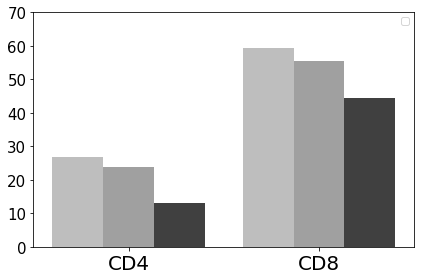

In [6]:
sns.barplot(x='Cell',y='Overlap',hue='Chain',data=df,palette=['DarkGray','Gray','Black'],alpha=.75)
plt.legend('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.ylim([0,70])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(figureroot+'Figure1_A'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

In [7]:
def venn_diagrams(cd4,cd8,chains,figure,color):
    four=np.unique(np.setdiff1d(cd4[chains],cd8[chains]))
    eight=np.unique(np.setdiff1d(cd8[chains],cd4[chains]))
    overlap=np.intersect1d(cd4[chains],cd8[chains])
    print(four.shape[0],overlap.shape[0],eight.shape[0])
    c=venn2_circles(subsets = (four.shape[0],eight.shape[0],overlap.shape[0]))
    c[0].set_lw(6)
    c[0].set_edgecolor(color)
    c[1].set_lw(6)
    c[1].set_edgecolor(color)
    plt.tight_layout()
    plt.savefig(figureroot+figure+'.eps',format='eps', dpi=1200)
    plt.show()
    plt.close()

49468 5593 16629


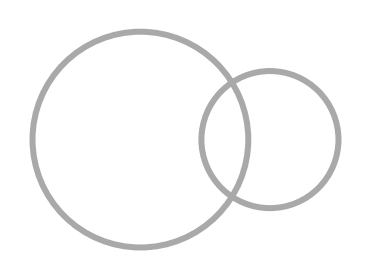

56458 3731 19119


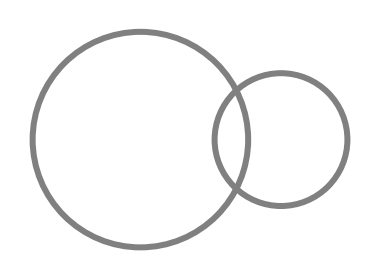

69437 632 26297


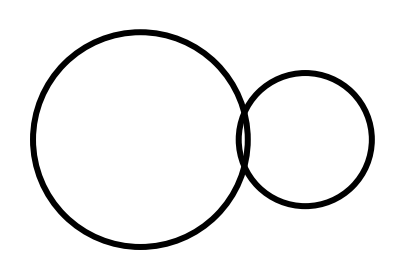

In [8]:
for (chains,figure,color) in zip(['Alpha','Beta','Pairs'],['Fig1_B','Fig1_C','Fig1_D'],['DarkGray','Gray','Black']):
    venn_diagrams(cd4,cd8,chains,figure,color)

In [9]:
def jaccard(cd4,cd8,chain):
    jaccard=[]
    for i in cd4.Subject.unique():
        subject4=cd4[cd4.Subject==i][chain]
        subject8=cd8[cd8.Subject==i][chain]
        intersection=np.intersect1d(subject4,subject8).shape[0]
        union=np.union1d(subject4,subject8).shape[0]
        jaccard.append(intersection/union)
    return pd.DataFrame(np.vstack((jaccard,[chain]*len(jaccard),np.arange(1,i+2))).T,columns=['Jaccard','Chain','Subject'])

In [10]:
for i,chain in enumerate(['Alpha','Beta','Pairs']):
    if i==0:
        df=jaccard(cd4,cd8,chain)
    else:
        df=df.append(jaccard(cd4,cd8,chain))
df.Jaccard=df.Jaccard.astype(float)

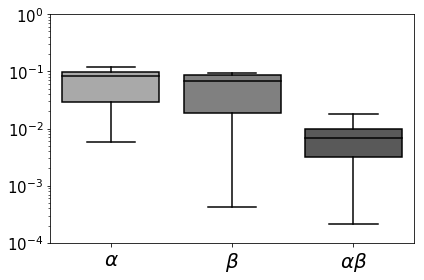

In [11]:
ax=sns.boxplot(x="Chain",y="Jaccard",data=df.drop(index=[5]),palette=['DarkGray','Gray','Black'])
r, g, d, a = ax.artists[2].get_facecolor()
ax.artists[2].set_facecolor((r, g, d, .65))    
plt.yscale('log')
plt.ylim((0.0001, 1))
plt.xticks(np.arange(0, 3, 1.0),[r'$\alpha$',r'$\beta$',r'$\alpha\beta$'],fontsize = 20)
plt.yticks(fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(figureroot+'Figure1_E'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

In [12]:
print('Alpha:Beta pvalue '+ str(stats.ttest_rel(df[df.Chain=='Alpha'].Jaccard,df[df.Chain=='Beta'].Jaccard)[1]))
print('Alpha:AlphaBeta pvalue '+ str(stats.ttest_rel(df[df.Chain=='Alpha'].Jaccard,df[df.Chain=='Pairs'].Jaccard)[1]))
print('Beta:AlphaBeta pvalue '+ str(stats.ttest_rel(df[df.Chain=='Beta'].Jaccard,df[df.Chain=='Pairs'].Jaccard)[1]))

Alpha:Beta pvalue 0.006571415718183489
Alpha:AlphaBeta pvalue 0.022307169579044727
Beta:AlphaBeta pvalue 0.030975632963750183


In [13]:
def overlapping_lengths(cd4,cd8,chains):
    four=np.unique(np.setdiff1d(cd4[chains],cd8[chains]))
    eight=np.unique(np.setdiff1d(cd8[chains],cd4[chains]))
    single=np.hstack((four,eight))
    overlap=np.intersect1d(cd4[chains],cd8[chains])
    single=list(map(len,[x[x.find('*')+1:] for x in single]))
    overlap=list(map(len,[x[x.find('*')+1:] for x in overlap]))
    if chains=='Pairs':
        single=np.array(single)-1
        overlap=np.array(overlap)-1
    lengths=np.hstack((single,overlap))
    cell=np.hstack((['Single']*len(single),['Overlap']*len(overlap)))
    chain=[chains]*len(lengths)
    return pd.DataFrame(np.vstack((lengths,cell,chain)).T,columns=['Lengths','Cell','Chain'])

In [14]:
cd4['Pairs']=cd4.Va+cd4.Vb+'*'+cd4.CDR3a+'_'+cd4.CDR3b
cd8['Pairs']=cd8.Va+cd8.Vb+'*'+cd8.CDR3a+'_'+cd8.CDR3b
cd4['Alpha']=cd4.Va+'*'+cd4.CDR3a
cd4['Beta']=cd4.Vb+'*'+cd4.CDR3b
cd8['Alpha']=cd8.Va+'*'+cd8.CDR3a
cd8['Beta']=cd8.Vb+'*'+cd8.CDR3b
for i,chain in enumerate(['Alpha','Beta','Pairs']):
    if i==0:
        df=overlapping_lengths(cd4,cd8,chain)
    else:
        df=df.append(overlapping_lengths(cd4,cd8,chain))
df.Lengths=[float(y)/2 if x in ['Pairs'] else float(y) for (x,y) in zip(df.Chain,df.Lengths)]

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


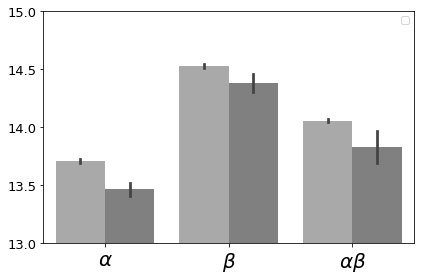

In [15]:
sns.barplot(x='Chain',y='Lengths',hue='Cell',data=df,hue_order=['Single','Overlap'],ci=99,palette=['Darkgray','Gray'])
plt.yticks(np.arange(13,15.5,.5),fontsize=13)
plt.xticks(np.arange(0, 3, 1.0),[r'$\alpha$',r'$\beta$',r'$\alpha\beta$'],fontsize = 20)
plt.xlabel('')
plt.ylabel('')
plt.ylim([13,15])
plt.legend('')
plt.tight_layout()
plt.savefig(figureroot+'Figure1_F'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

In [16]:
def get_sequences(cd4,cd8,chains):
    four=np.unique(np.setdiff1d(cd4[chains],cd8[chains]))
    eight=np.unique(np.setdiff1d(cd8[chains],cd4[chains]))
    single=np.hstack((four,eight))
    overlap=np.intersect1d(cd4[chains],cd8[chains])
    single=[x[x.find('*')+1:] for x in single]
    overlap=[x[x.find('*')+1:] for x in overlap]
    if chains!='Pairs':
        np.savetxt(chains+'single.txt',single,fmt='%s')
        np.savetxt(chains+'overlap.txt',overlap,fmt='%s')
    else:
        single=[[x[:x.find('_')],x[x.find('_')+1:]] for x in single]
        single_alpha=np.array(single)[:,0]
        single_beta=np.array(single)[:,1]
        np.savetxt(chains+'single_alpha.txt',single_alpha,fmt='%s')
        np.savetxt(chains+'single_beta.txt',single_beta,fmt='%s') 
        overlap=[[x[:x.find('_')],x[x.find('_')+1:]] for x in overlap]
        overlap_alpha=np.array(overlap)[:,0]
        overlap_beta=np.array(overlap)[:,1]
        np.savetxt(chains+'overlap_alpha.txt',overlap_alpha,fmt='%s')
        np.savetxt(chains+'overlap_beta.txt',overlap_beta,fmt='%s')

In [17]:
for i,chain in enumerate(['Alpha','Beta','Pairs']):
    get_sequences(cd4,cd8,chain)

In [18]:
alpha_single=np.genfromtxt('/Users/jac/Alphasingle_prob.txt',dtype='unicode',delimiter='\t')[:,1]
alpha_overlap=np.genfromtxt('/Users/jac/Alphaoverlap_prob.txt',dtype='unicode',delimiter='\t')[:,1]

In [19]:
beta_single=np.genfromtxt('/Users/jac/Betasingle_prob.txt',dtype='unicode',delimiter='\t')[:,1]
beta_overlap=np.genfromtxt('/Users/jac/Betaoverlap_prob.txt',dtype='unicode',delimiter='\t')[:,1]

In [20]:
pairs_alpha=np.genfromtxt('/Users/jac/Parissingle_alpha_prob.txt',dtype='unicode',delimiter='\t')[:,1]
pairs_beta=np.genfromtxt('/Users/jac/Parissingle_Beta_prob.txt',dtype='unicode',delimiter='\t')[:,1]
pairs_overlapa=np.genfromtxt('/Users/jac/Parisoverlap_alpha_prob.txt',dtype='unicode',delimiter='\t')[:,1]
pairs_overlapb=np.genfromtxt('/Users/jac/Parisoverlap_beta_prob.txt',dtype='unicode',delimiter='\t')[:,1]
pairs_overlap=np.array(pairs_overlapb).astype(float)+np.array(pairs_overlapa).astype(float)
pairs_single=np.array(pairs_alpha).astype(float)+np.array(pairs_beta).astype(float)
pairs_overlap=pairs_overlap/2
pairs_single=pairs_single/2

In [21]:
a=np.vstack((alpha_single,['Alpha']*alpha_single.shape[0],['Single']*alpha_single.shape[0])).T
b=np.vstack((alpha_overlap,['Alpha']*alpha_overlap.shape[0],['Overlap']*alpha_overlap.shape[0])).T
c=np.vstack((beta_single,['Beta']*beta_single.shape[0],['Single']*beta_single.shape[0])).T
d=np.vstack((beta_overlap,['Beta']*beta_overlap.shape[0],['Overlap']*beta_overlap.shape[0])).T
e=np.vstack((pairs_overlap,['Pairs']*pairs_overlap.shape[0],['Overlap']*pairs_overlap.shape[0])).T
f=np.vstack((pairs_single,['Pairs']*pairs_single.shape[0],['Single']*pairs_single.shape[0])).T
df=pd.DataFrame(np.vstack((a,b,c,d,e,f)),columns=['Prob','Chain','Cell'])
df.Prob=df.Prob.astype(float)

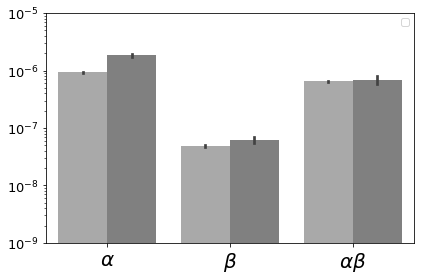

In [22]:
sns.barplot(x='Chain',y='Prob',hue='Cell',data=df,palette=['DarkGray','Gray'])
plt.yscale('log')
plt.ylim([10e-10,10e-6])
plt.legend('')
plt.xticks(np.arange(0, 3, 1.0),[r'$\alpha$',r'$\beta$',r'$\alpha\beta$'],fontsize = 20)
plt.yticks(fontsize=13)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(figureroot+'Figure1_G'+'.png',format='png', dpi=1200)

In [23]:
stats.mannwhitneyu(np.array(beta_overlap).astype(float),np.array(beta_single).astype(float))

MannwhitneyuResult(statistic=138669380.0, pvalue=0.0446502423873256)

In [24]:
stats.mannwhitneyu(np.array(alpha_overlap).astype(float),np.array(alpha_single).astype(float))

MannwhitneyuResult(statistic=150512829.5, pvalue=2.340369864896088e-118)

In [25]:
stats.mannwhitneyu(np.array(pairs_overlap).astype(float),np.array(pairs_single).astype(float))

MannwhitneyuResult(statistic=29470229.5, pvalue=0.1310466510462665)